In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic


from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import os

from torchvision.transforms.functional import rotate
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torch.utils.data import Subset
import scipy
import os

In [2]:
n_x = 64
dims = [n_x, n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#spath = Path('../trash/GP')
spath = Path('your_path/SDF_MNIST_prior')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
torch.manual_seed(22) # fix the seed for reproducible regression result
modes = 16 # can be applied to 32x32, or 128x128..
width = 128
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

## training parameters
epochs = 100
sigma_min=1e-4
N = 1
batch_size = 512

In [3]:
def get_mgrid(sidelen):
    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen    
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

class SignedDistanceTransform:
    def __call__(self, img_tensor):
        # Threshold.
        img_tensor[img_tensor<0.5] = 0.
        img_tensor[img_tensor>=0.5] = 1.

        # Compute signed distances with distance transform
        img_tensor = img_tensor.numpy()

        neg_distances = scipy.ndimage.distance_transform_edt(img_tensor)
        sd_img = img_tensor - 1.
        sd_img = sd_img.astype(np.uint8)
        signed_distances = scipy.ndimage.distance_transform_edt(sd_img) - neg_distances
        signed_distances /= float(img_tensor.shape[1])
        signed_distances = torch.Tensor(signed_distances)

        return signed_distances, torch.Tensor(img_tensor)
    
class MNISTSDFDataset(torch.utils.data.Dataset):
    def __init__(self, split, size=(256,256), subset=True, n_samples=6000): #60000 samples in total
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            SignedDistanceTransform(),
        ])
        img_dataset = torchvision.datasets.MNIST('../data/MNIST', train=True if split == 'train' else False,
                                                download=False)
        if subset == True:
            subset_indices = np.random.choice(len(img_dataset), n_samples, replace=False)
            self.img_dataset = Subset(img_dataset, subset_indices)
            self.n_samples = n_samples
        else:
            self.img_dataset = img_dataset
            self.n_samples = len(img_dataset)
        
        self.meshgrid = get_mgrid(size[0])
        self.im_size = size

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)
        #print('signed_distance_img shape:{}'.format(signed_distance_img.shape))
        #signed_distance_values = signed_distance_img.reshape((-1, 1))
        
        return signed_distance_img
    
    def get_N_samples(self, N=10, random=True):
        if random==True:
            sample_ids = np.random.choice(self.n_samples, N, replace=False)
        else:
            sample_ids = np.arange(N)
        samples = []
        for sample_id in sample_ids:
            
            img, digit_class = self.img_dataset[sample_id]
            signed_distance_img, binary_image = self.transform(img)
            samples.append(signed_distance_img)
            
        return torch.vstack(samples)
        
    def get_dict(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)
        
        coord_values = self.meshgrid.reshape(-1, 2)
        signed_distance_values = signed_distance_img.reshape((-1, 1))
        
        indices = torch.randperm(coord_values.shape[0])
        support_indices = indices[:indices.shape[0]//2]
        query_indices = indices[indices.shape[0]//2:]

        meta_dict = {'context': {'x':coord_values[support_indices], 'y':signed_distance_values[support_indices]}, 
                     'query': {'x':coord_values[query_indices], 'y':signed_distance_values[query_indices]}, 
                     'all': {'x':coord_values, 'y':signed_distance_values}}
        
        return meta_dict
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

In [4]:
val_dataset = MNISTSDFDataset('val', subset=False, size=(64, 64))
x_test = val_dataset.get_N_samples(N=6000, random=False).unsqueeze(1)

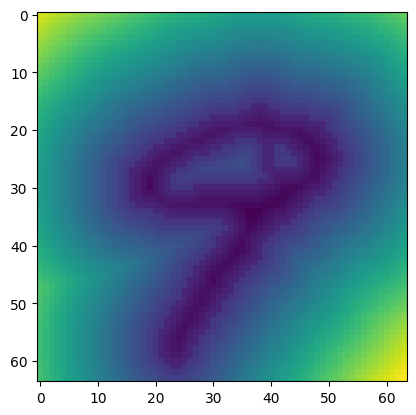

In [6]:
plt.imshow(x_test[9,0])

## load trained model

In [7]:
spath

PosixPath('/net/ghisallo/scratch1/yshi5/OFM/SDF_MNIST_prior')

In [8]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
 
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_100.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [9]:
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

/home/yshi5/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


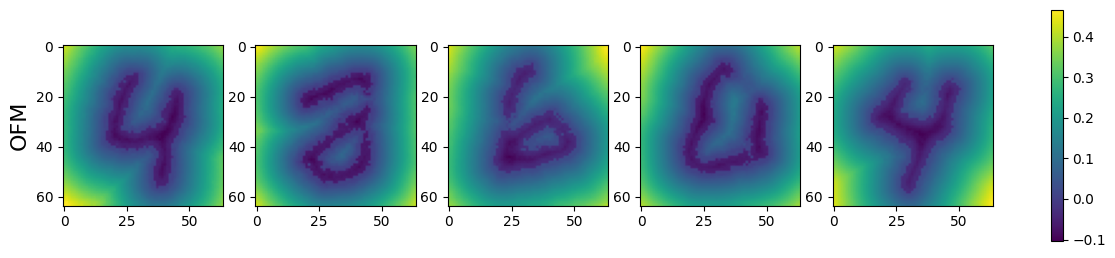

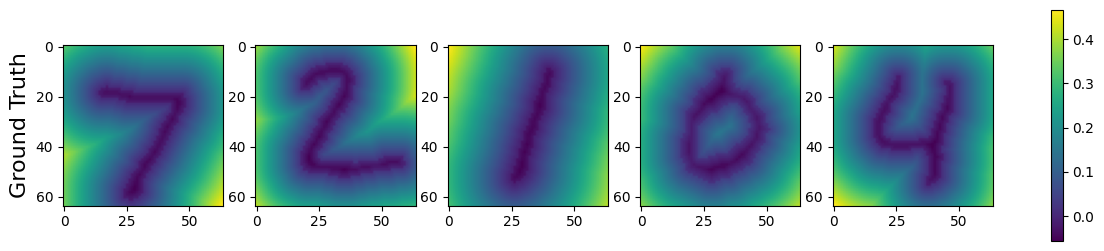

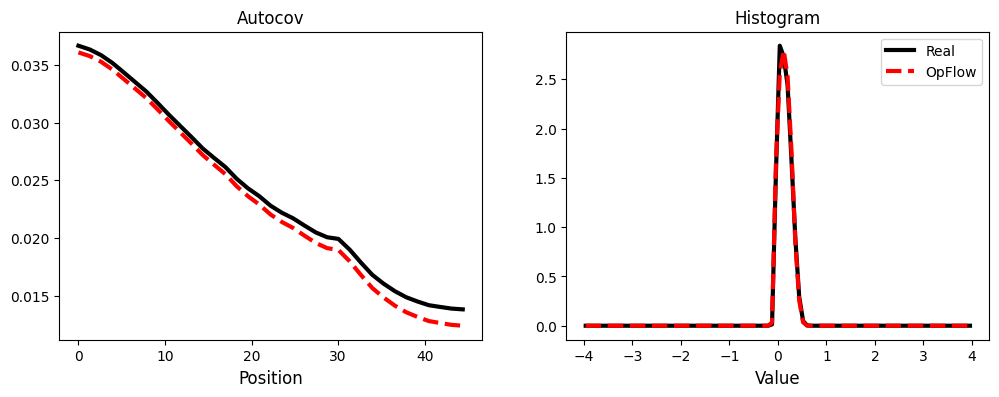

In [10]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_test[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x, n_x], n_samples=200, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_test.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_test.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
    #plt.show()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)

    bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(bin_center, x_acovf_true, c='k', lw=3)
    ax[0].plot(bin_center, x_acovf, c='r',ls='--', lw=3)
    #ax[0].set_ylim(0.2, 0.45)
    ax[0].set_title('Autocov')
    ax[0].set_xlabel('Position', fontsize='large')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[1].set_title('Histogram')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Value', fontsize='large')
    #plt.savefig("plots/GP2GP/epoch_{}.pdf".format(epoch))

## 2D Regression

2D Regression
$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [10]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2
    
ndim = 64
lr = 1e-3 
epochs = 1000
noise_level = 0.001

# extract 64 random observations from a test sample
berno_mask = torch.zeros((ndim, ndim))

mask_idx = np.random.choice(ndim*ndim, 64,replace=False)


berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(ndim,ndim)
pos_mask = (berno_mask == 1)

# The ground truth that we used to extract random observation
u_obs_full = x_test[0:1,:]
u_obs_part = u_obs_full[:,:, pos_mask].to(device)

noise_pattern =  torch.randn_like(u_obs_part)
u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

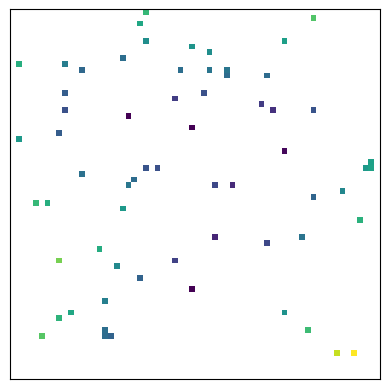

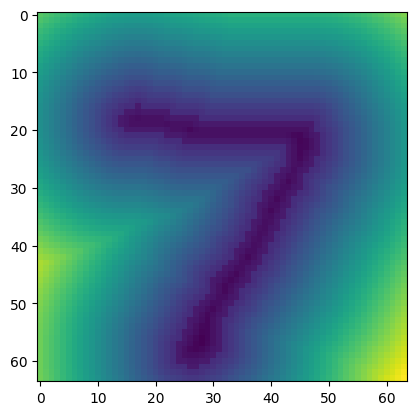

In [13]:
# for plotting the partial observation
add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern.detach().cpu()* np.sqrt(noise_level)).squeeze()
part_gt = u_obs_full.clone() + add_noise_plot
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)

plt.xticks([])
plt.yticks([])

plt.show()
plt.figure()
plt.imshow(x_test[0,0])

In [14]:
G = fmot

# Get the MAP result (optional)

In [39]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,1, ndim, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=4, forward=True)
        
    def logp(self):
        # take more time to average out
        u, out_logp, prior_logp = self.G.data_likelihood_precise(self.a_target, n_eval=4, forward=True,n_repeat=8)

        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:, :, pos_mask])**2)/noise_level
        #loss2 = reg_opflow_a.logp()
        loss1 = -0.5*torch.sum((u_obs_part.squeeze() - cur_u[:, pos_mask].squeeze())**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [40]:
## initialize this with the 

In [41]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [42]:

a_init_value =fmot.inv_sample(torch.Tensor(u_obs_full).unsqueeze(0).unsqueeze(1).to(device), n_eval=4, forward=False)
reg_opflow_a.initialize(a_init_value.detach().cpu())

In [ ]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

In [45]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [46]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()


(4096, 2)


## SGLD

In [ ]:
"""
# for arius, memory constrain
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary()) 
"""


In [20]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_990912/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [22]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise(a, n_eval=4, forward=True,n_repeat=8)
    loss1 = -0.5*torch.sum((u_obs_part - cur_u[:,  pos_mask])**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [23]:
a_opflow_copy = x_test[0:1]

In [24]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)


temperature = 1
momentum = 0

max_itr = int(2e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )


hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [9:24:51<00:00,  1.69s/it]


In [26]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True).cpu().detach())

u_samples_all = torch.vstack(u_samples_all)

In [ ]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(3000, len(loss_log)),loss_log[3000:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [30]:
## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:]
#est_samples = est_samples[::50]

sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

## Final Plots

In [31]:

opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)


(4096, 2)


In [ ]:
## Fit the best GP
true_kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(1e-1, 0.5), nu=1.5)  + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-2, 0.05))

gpr = GaussianProcessRegressor(kernel=true_kernel, alpha=0)

gpr = gpr.fit(x_obs, y_obs) #update the GP model 


print(f"Initial: {true_kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: ")

In [33]:
true_kernel = 0.187**2 * Matern(length_scale=0.5, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=0.01)

gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 


In [37]:
saved_folder = 'GRF2GRF_SDF_MNIST_sup'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

In [34]:
from matplotlib.colors import TwoSlopeNorm

In [ ]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(ndim,ndim)
y_std = y_std.reshape(ndim,ndim)
y_samples = gpr_model_ground_truth.sample_y(X, 1000).reshape(ndim,ndim,-1)

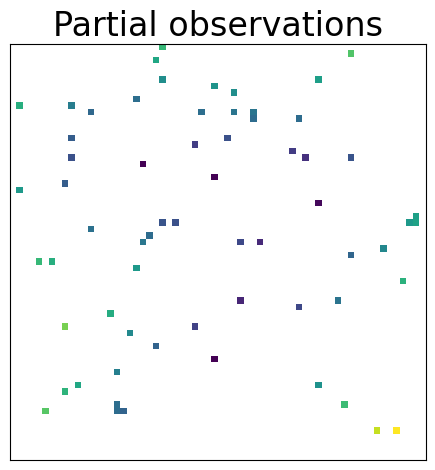

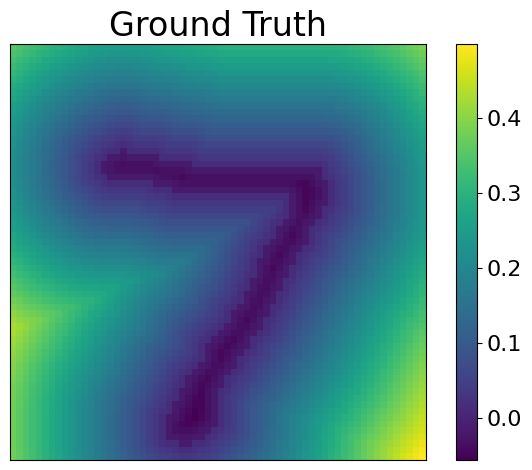

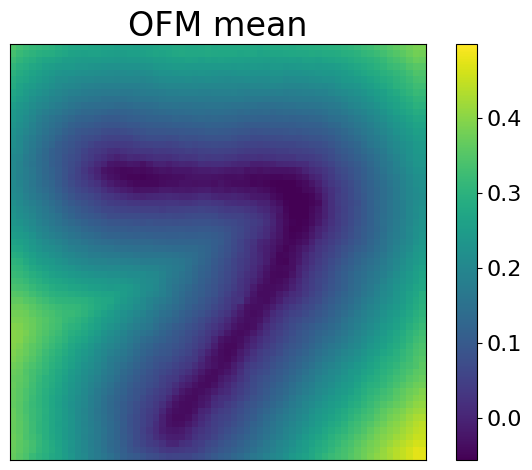

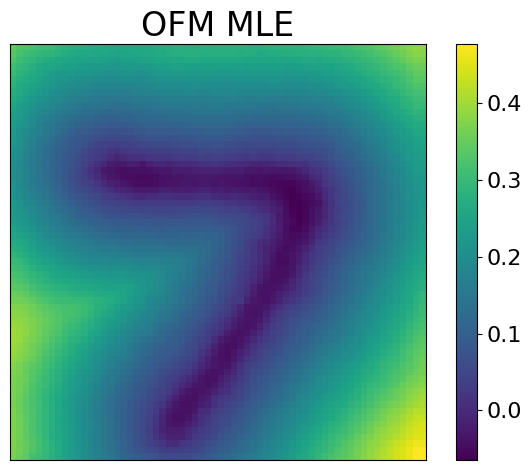

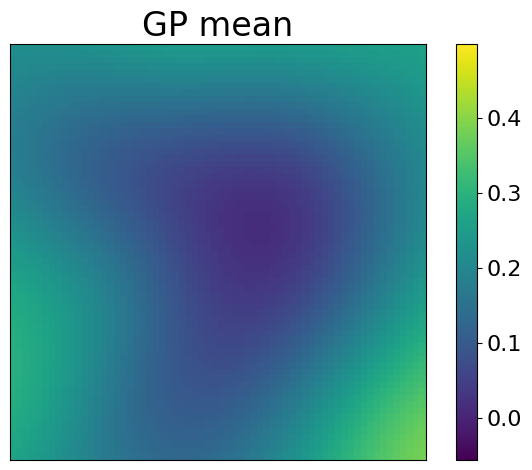

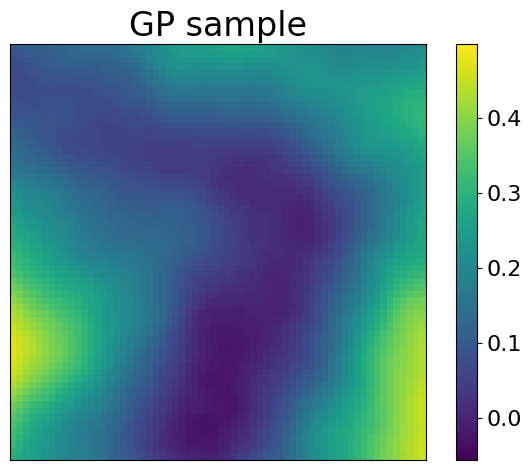

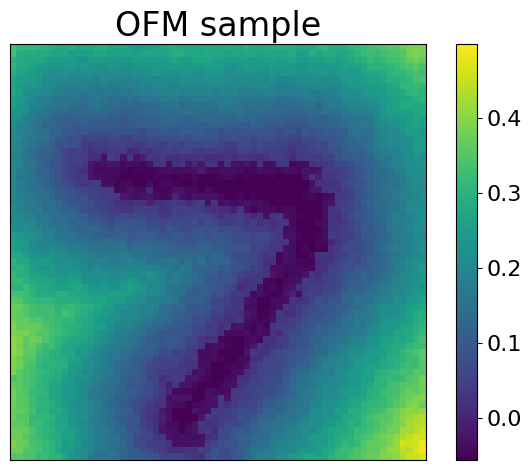

In [38]:


### plot parameter
y_min_plot, y_max_plot = u_obs_full.min(), u_obs_full.max()

#y_abs_max = np.abs(y_mean).max()

# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial observations', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_partial_obs_sup.pdf")


plt.figure()
plt.imshow(u_obs_full, vmin=y_min_plot, vmax=y_max_plot)
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('Ground Truth', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_gt_sup.pdf")


plt.figure()
plt.imshow(sample_mean, vmin=y_min_plot, vmax=y_max_plot)
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM mean', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_ofm_mean_sup.pdf")


plt.figure()
plt.imshow(u_opflow.clone().detach().cpu().squeeze(), vmin=y_min_plot, vmax=y_max_plot)
plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM MLE', fontsize=24)
plt.tight_layout()
#plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_ofm_MLE.pdf")

plt.figure()
plt.imshow(y_mean, vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('GP mean', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_gp_mean_sup.pdf")


plt.figure()
plt.imshow(y_samples[:,:,0], vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('GP sample', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_gp_sample_sup.pdf")

plt.figure()
plt.imshow(est_samples[600].squeeze(), vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM sample', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_ofm_sample.pdf")

## Generate 3 representative scenarios

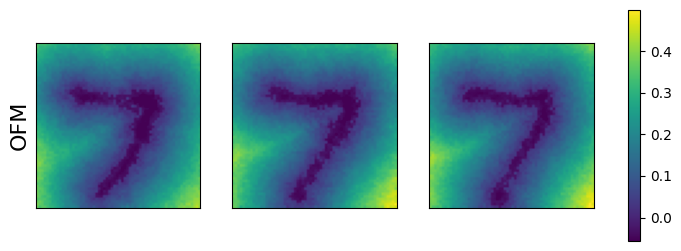

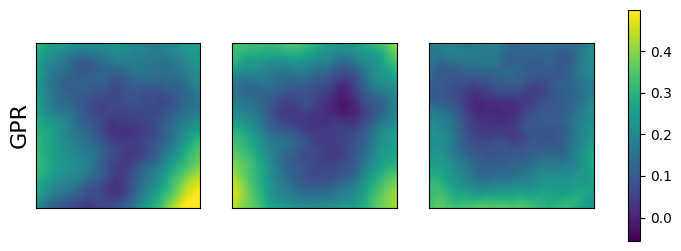

In [39]:
## each one generate 3 plots
## For the scenario, select 3 representative scenario for OpFlow and Ground Truth

random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow,  vmin=y_min_plot, vmax=y_max_plot)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OFM', fontsize=16)
        
bar = ax[2].imshow(x_opflow,  vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=ax)    
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_scen_ofm_sup.pdf")

random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('GPR', fontsize=16)
        
bar = ax[2].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=ax)   
plt.savefig(f"../Regression_results/{saved_folder}/MNIST_SDF_reg_scen_gt_sup.pdf")


In [41]:
import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()